
model to choose from:
* Unet
* Unet++
* MAnet
* Linknet
* FPN
* PSPNet
* PAN
* DeepLabV3
* DeepLabV3+
* UPerNet
* Segformer


Steps:

 - `Datasets` and `DataLoaders` preparation (with predefined dataset class).  
 - `LightningModule` preparation: defining training, validation and test routines.  
 - Writing `IoU` metric inside the `LightningModule` for measuring quality of segmentation.  
 - Results visualization.


 referencel:https://github.com/qubvel-org/segmentation_models.pytorch

In [ ]:
%%capture
!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
!pip install lightning albumentations

In [ ]:
import os

import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import numpy as np

## Dataset

In this example we will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

#### dataset sample

In [ ]:
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [ ]:
# download data
root = "."
SimpleOxfordPetDataset.download(root)

In [ ]:
# init train, val, test sets
train_dataset = SimpleOxfordPetDataset(root, "train")
valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(root, "test")

# It is a good practice to check datasets don`t intersects with each other
assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=n_cpu
)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=n_cpu
)
test_dataloader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=n_cpu
)

Train size: 3312
Valid size: 368
Test size: 3669


In [ ]:
train_dataset[0]["mask"].shape

(1, 256, 256)

In [ ]:
# train_dataset[0]["image"].shape
# 获取一个批次数据
batch = next(iter(train_dataloader))

# 获取图像和标签
images = batch["image"]
labels = batch["mask"]

# 打印图像和标签的形状
print(f"Image shape: {images.shape}")
print(f"Label shape: {labels.shape}")

Image shape: torch.Size([64, 3, 256, 256])
Label shape: torch.Size([64, 1, 256, 256])


#### favela data

In [ ]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import torchvision.transforms as transforms

In [ ]:
import roboflow
from roboflow import Roboflow

rf = Roboflow(api_key="uZgVV5Mu30Veqelqd61T")
project = rf.workspace("my-second-workspace-for-favela").project("ss_rio_tile1024_stride0")
version = project.version(4) #updated
dataset = version.download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor

        self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        with open(self.classes_csv_file, 'r') as fid:
            data = [l.split(',') for i,l in enumerate(fid) if i !=0]
        self.id2label = {x[0]:x[1] for x in data}

        image_file_names = [f for f in os.listdir(self.root_dir) if '.jpg' in f]
        mask_file_names = [f for f in os.listdir(self.root_dir) if '.png' in f]

        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.root_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.root_dir, self.masks[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k, v in encoded_inputs.items():
            if k == "pixel_values":
                # Remove batch dimension for pixel values, revised
                encoded_inputs[k] = v.squeeze(0)

        return encoded_inputs


# class SemanticSegmentationDataset_plain(Dataset):
#     """Image (semantic) segmentation dataset."""

#     def __init__(self, root_dir):
#         """
#         Args:
#             root_dir (string): Root directory of the dataset containing the images + annotations.
#             feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
#             train (bool): Whether to load "training" or "validation" images + annotations.
#         """
#         self.root_dir = root_dir
#         # self.feature_extractor = feature_extractor

#         self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
#         with open(self.classes_csv_file, 'r') as fid:
#             data = [l.split(',') for i,l in enumerate(fid) if i !=0]
#         self.id2label = {x[0]:x[1] for x in data}

#         image_file_names = [f for f in os.listdir(self.root_dir) if '.jpg' in f]
#         mask_file_names = [f for f in os.listdir(self.root_dir) if '.png' in f]

#         self.images = sorted(image_file_names)
#         self.masks = sorted(mask_file_names)

#         # 定义图像和分割图的预处理步骤
#         self.image_transform = transforms.Compose([
#             transforms.Resize((128, 128)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ])
#         self.mask_transform = transforms.Compose([
#             transforms.Resize((128, 128)),
#             transforms.ToTensor(),
#         ])

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):

#         image = Image.open(os.path.join(self.root_dir, self.images[idx]))
#         segmentation_map = Image.open(os.path.join(self.root_dir, self.masks[idx]))

#         # randomly crop + pad both image and segmentation map to same size
#         # encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

#         # for k,v in encoded_inputs.items():
#         #   encoded_inputs[k].squeeze_() # remove batch dimension

#         # 直接在数据加载器中进行预处理
#         image = self.image_transform(image)
#         segmentation_map = self.mask_transform(segmentation_map)

#         return {"pixel_values": image, "labels": segmentation_map}

#         return encoded_inputs

In [ ]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# 禁用归一化，revised
feature_extractor.image_mean = [0.0, 0.0, 0.0]
feature_extractor.image_std = [1.0, 1.0, 1.0]

feature_extractor.do_reduce_labels = False
feature_extractor.size = 256

train_dataset = SemanticSegmentationDataset(f"{dataset.location}/train/", feature_extractor)
valid_dataset = SemanticSegmentationDataset(f"{dataset.location}/valid/", feature_extractor)
test_dataset = SemanticSegmentationDataset(f"{dataset.location}/test/", feature_extractor)

batch_size = 64
num_workers = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'


In [ ]:
print("pixel_values",train_dataset[0]["pixel_values"].shape)
print("labels",train_dataset[0]["labels"].shape)

pixel_values torch.Size([3, 256, 256])
labels torch.Size([1, 256, 256])


In [ ]:
# 获取一个批次数据
batch = next(iter(train_dataloader))

# 获取图像和标签
images = batch["pixel_values"]
labels = batch["labels"]

# 打印图像和标签的形状
print(f"Image shape: {images.shape}")
print(f"Label shape: {labels.shape}")

Image shape: torch.Size([64, 3, 256, 256])
Label shape: torch.Size([64, 1, 256, 256])


In [ ]:
## TBD 这个归一化好像有点不大对

sample = train_dataset[0]

pixel_values = sample["pixel_values"]
pixel_values.shape

min_value = pixel_values.min().item()  # 获取最小值
max_value = pixel_values.max().item()  # 获取最大值

print(f"Pixel values range: [{min_value}, {max_value}]")

Pixel values range: [0.05098039284348488, 0.929411768913269]


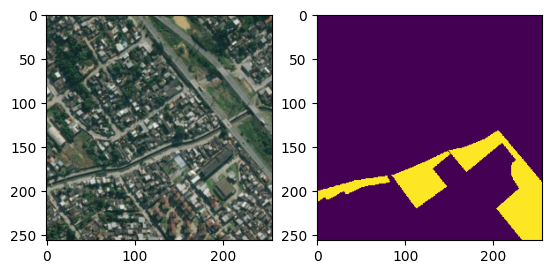

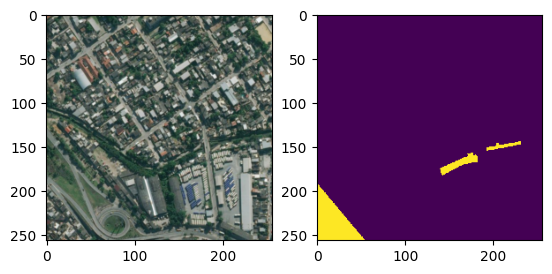

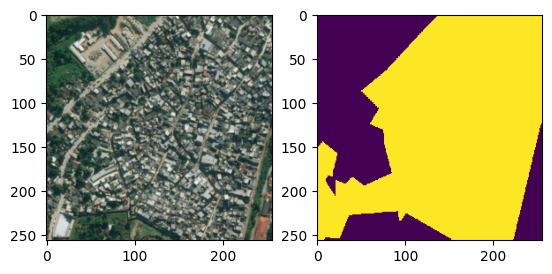

In [ ]:
# lets look at some samples


def visualize_sample(sample, pixel_values_key="pixel_values", labels_key="labels", figsize=(10, 5)):
    """
    可视化数据样本的图像和掩码。
    """
    plt.subplot(1, 2, 1)
    # for visualization we have to transpose back to HWC [channels, height, width], 如果像素值在 [0, 1] 或 [0, 255] 范围内
    plt.imshow(sample[pixel_values_key].permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    # for visualization we have to remove 3rd dimension of mask
    plt.imshow(sample[labels_key].squeeze())
    plt.show()


visualize_sample(train_dataset[0])
visualize_sample(valid_dataset[0])
visualize_sample(test_dataset[0])


# sample = test_dataset[0]
# plt.subplot(1, 2, 1)
# # for visualization we have to transpose back to HWC
# plt.imshow(sample["image"].transpose(1, 2, 0))
# plt.subplot(1, 2, 2)
# # for visualization we have to remove 3rd dimension of mask
# plt.imshow(sample["mask"].squeeze())
# plt.show()

## Model

In [ ]:
# Some training hyperparameters
EPOCHS = 20
T_MAX = EPOCHS * len(train_dataloader)
OUT_CLASSES = 1

In [ ]:
class PetModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes,  encoder_weights, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            encoder_weights=encoder_weights,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["pixel_values"] # image

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4 # revise

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["labels"] # mask
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [ ]:
# model = PetModel("FPN", "resnet34", in_channels=3, out_classes=1)
model = PetModel("Unet",
          "resnet34",
          in_channels=3,
          out_classes=1,
          encoder_weights="imagenet")

In [ ]:
print(model)

PetModel(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

## Training

In [ ]:
# import segmentation_models_pytorch as smp

# model = smp.Unet(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=3,                      # model output channels (number of classes in your dataset)
# )

In [ ]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 24.4 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)
189       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


看valid dataset IOU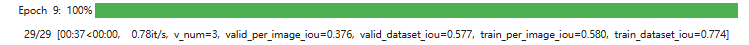


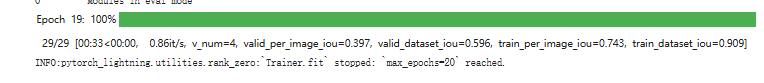
todo:要拉齐

## Validation and test metrics

In [ ]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

In [ ]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.9075158834457397, 'test_dataset_iou': 0.9144099950790405}]


# Save model to HF Hub

Login to [HF hub](https://huggingface.co/) if you want to save your model to the hub. Then, you will be able to save and load model, save metrics, and dataset name!

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# get original model from lightning PetModel
smp_model = model.model
# if push_to_hub=True, model will be saved to repository with this name
commit_info = smp_model.save_pretrained(
    save_directory="ytzfhqs/oxford-pet-segmentation",
    push_to_hub=True,  # optional, push model to HF Hub
    metrics=test_metrics,  # optional, save metrics in model card
    dataset="Oxford Pet",  # optional, save dataset name in model card
)

model.safetensors:   0%|          | 0.00/92.7M [00:00<?, ?B/s]

In [ ]:
# Then you can load model from hub
loaded_model = smp.from_pretrained("ytzfhqs/oxford-pet-segmentation")
print("Loaded model:", loaded_model.__class__.__name__)

config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

Loading weights from local directory
Loaded model: FPN


# Result visualization

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


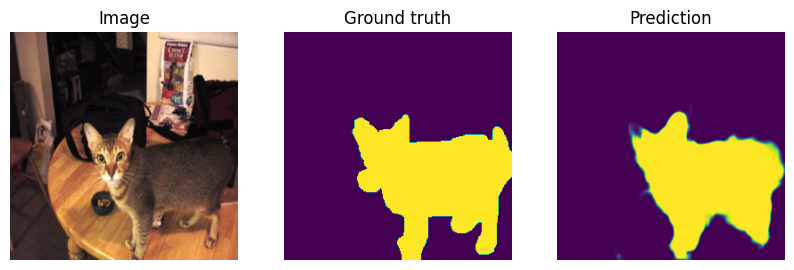

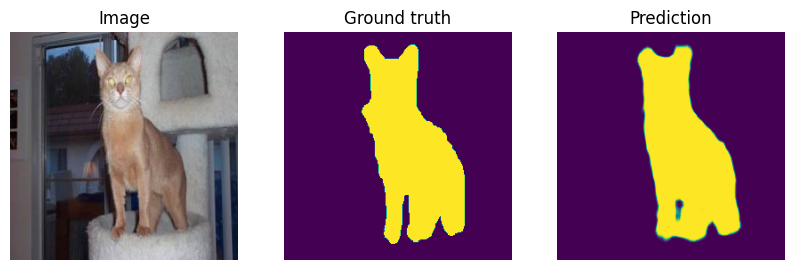

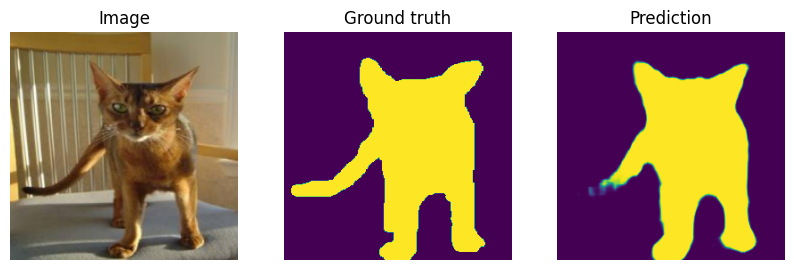

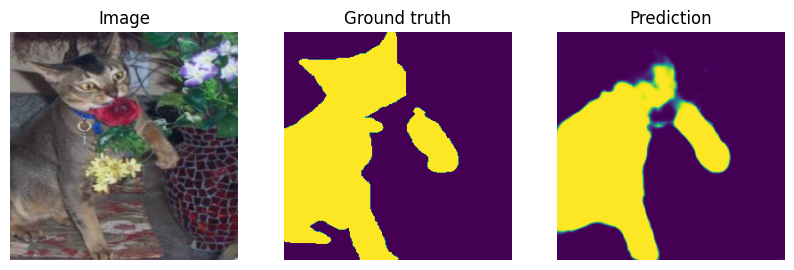

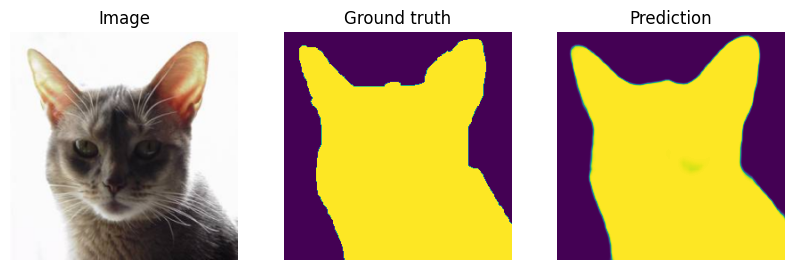

In [ ]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], pr_masks)
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break